In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-003_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-004_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-005_1.jpg (0 in cache)']

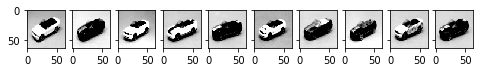

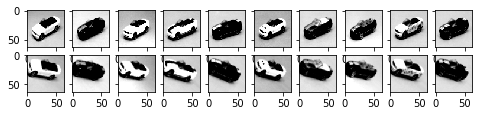

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

def transform(params, img):
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    xformed = datagen.apply_transform(x=img,
                                      transform_parameters=params)
    xformed = np.reshape(xformed, (xformed.shape[0], xformed.shape[1]))
    return xformed

transform_parameters = {
    'theta':40,
    'tx':5.0,
    'ty':5.0,
    'zx':0.9,
    'zy':0.9
}

_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)
show_processed_strip = True
if show_processed_strip:
    _, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
    processed_dict = {img.fullpath:transform(transform_parameters, img.get_processed_image()) for img in imgs}
    show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.executing_eagerly()

False

In [20]:
use_cpu = False
if use_cpu:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from model_vae_3stage import ModelVae3Stage
all_model = ModelVae3Stage(size=128, in_channels=1, latent_dim=8)
vae, enc, dec = all_model.vae, all_model.encoder, all_model.decoder

In [21]:
import numpy as np
import random
random.shuffle(imgs)
x_train = [img.get_processed_image(size=128) for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, 
                     (x_train.shape[0], 
                      x_train.shape[1], 
                      x_train.shape[2], 1))

test_size = len(x_train) // 10
x_test = x_train[0:test_size]
x_train = x_train[test_size+1:]
x_train.shape, x_test.shape

((579, 128, 128, 1), (64, 128, 128, 1))

In [29]:
use_generator = True
if use_generator:
    def generator(x_train, batch_size):
        # Create empty arrays to contain batch of features and labels
        batch_train = np.zeros((batch_size, 
                                x_train.shape[1], 
                                x_train.shape[2], 
                                x_train.shape[3]))
        while True:
            for i in range(batch_size):
                # choose random index in features
                batch_train[i] = random.choice(x_train)
            yield batch_train, batch_train
    vae.fit_generator(generator(x_train, batch_size=256), 
                      steps_per_epoch=50, epochs=100)
else:
    vae.fit(x_train, x_train, epochs=100, batch_size=256,
        shuffle=True, validation_data=(x_test,x_test))

Epoch 1/100
50/50 [==============================] - 8s 167ms/step - loss: 876.9118
Epoch 2/100
50/50 [==============================] - 8s 167ms/step - loss: 870.6654
Epoch 3/100
50/50 [==============================] - 8s 168ms/step - loss: 856.0798
Epoch 4/100
50/50 [==============================] - 8s 167ms/step - loss: 870.6748
Epoch 5/100
50/50 [==============================] - 8s 167ms/step - loss: 873.7289
Epoch 6/100
50/50 [==============================] - 8s 167ms/step - loss: 870.5261
Epoch 7/100
50/50 [==============================] - 8s 168ms/step - loss: 869.8866
Epoch 8/100
50/50 [==============================] - 8s 166ms/step - loss: 857.6349
Epoch 9/100
50/50 [==============================] - 8s 168ms/step - loss: 871.1947
Epoch 10/100
50/50 [==============================] - 8s 167ms/step - loss: 872.6793
Epoch 11/100
50/50 [==============================] - 8s 168ms/step - loss: 865.8389
Epoch 12/100
50/50 [==============================] - 8s 168ms/step - loss

50/50 [==============================] - 8s 168ms/step - loss: 820.9610
Epoch 98/100
50/50 [==============================] - 8s 169ms/step - loss: 820.4699
Epoch 99/100
50/50 [==============================] - 8s 169ms/step - loss: 819.1324
Epoch 100/100
50/50 [==============================] - 8s 170ms/step - loss: 818.2158


In [30]:
def show_original_decoded(original, decoded, sz):
    from scipy import ndimage, misc
    from skimage.transform import resize
    
    n = 8  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i+1)
        orig_image = original[i].reshape(sz,sz)
        plt.imshow(orig_image, cmap='gray')
        
        ax = plt.subplot(2, n, i+1+n)
        decoded_image = decoded[i].reshape(sz,sz)
        plt.imshow(decoded_image, cmap='gray')
    plt.show()

(8, 128, 128, 1) -> (8, 8) -> (8, 128, 128, 1)


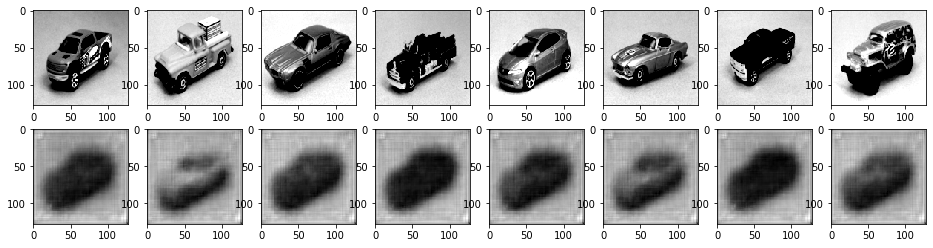

In [31]:
show_examples = np.append(x_train[0:4], x_test[0:4], axis=0)
encoded_latent = enc.predict(show_examples)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(show_examples.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(show_examples, decoded_imgs, 128)

In [10]:
vae.save('model_vae_3stage.h5')

In [11]:
with open("model_vae_3stage.yaml", "w") as yaml_model_file:
    yaml_model_file.write(vae.to_yaml())

In [12]:
import matplotlib.pyplot as plt
sz=256
def g(**kwargs):
    plt.figure(2, figsize=(4,4))
    # x = np.linspace(-10,10,num=1000)
    # plt.plot(x,kwargs['1']/100*x + kwargs['2'])
    # plt.ylim(-5,5)
    # plt.show()
    latent = np.array([list(kwargs.values())])
    # print(type(latent))
    # print(latent.shape)
    # latent.reshape(1,)
    # print(latent)
    decoded = dec.predict(latent)
    plt.imshow(decoded.reshape(sz,sz))
    plt.gray()
    return kwargs['1']

In [13]:
from ipywidgets import interactive_output,Layout
import ipywidgets as widgets

In [17]:
%matplotlib inline
latent_dim = encoded_latent[2].shape[-1]
def createSlider():
    return widgets.FloatSlider(value=0,
                               min=-6, max=6, step=0.1,
                               orientation='vertical',
                               layout=Layout(padding='0%'))
kwargs = {str(k):createSlider() for k in range(latent_dim)}
w = interactive_output(g,kwargs)                                  
hbox = widgets.HBox(list(kwargs.values()),
                    layout=Layout(padding='0%'))
display(hbox,w)

Output()